<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Lesson_27_PanopticFPN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Урок 27: Паноптическая сегментация — Panoptic FPN


## 📚 Теория: Паноптическая сегментация

Паноптическая сегментация объединяет два направления:

- **Семантическая сегментация** — определение класса для каждого пикселя
- **Instance-сегментация** — разделение объектов одного класса (например, людей) на уникальные экземпляры

### 🔧 Модель Panoptic FPN

Panoptic FPN основан на Feature Pyramid Network и использует две ветви:
- Instance ветка: Mask R-CNN
- Semantic ветка: сверточные upsampling модули

Итог — объединение двух масок в одну panoptic карту.

$$
\mathcal{L}_{total} = \lambda_1 \cdot \mathcal{L}_{instance} + \lambda_2 \cdot \mathcal{L}_{semantic}
$$



## 🛠️ Практика OpenCV: Паноптическая карта

1. Загрузите семантическую маску (напр. от DeepLab)
2. Загрузите instance маску (напр. от Mask R-CNN)
3. Объедините их в panoptic карту
4. Присвойте каждому instance уникальный цвет
5. Отобразите итоговую карту

### 📌 Подсказка:
```python
# Пример объединения масок
panoptic_map = semantic_mask.copy()
for instance_id, mask in enumerate(instance_masks):
    panoptic_map[mask == 1] = 100 + instance_id  # условная разметка
```



## 📐 Алгебра: Измерение расстояний по одной камере

При известной реальной высоте объекта можно рассчитать расстояние:

$$
Z = \frac{f \cdot H_{real}}{H_{img}}
$$

где:
- \( f \) — фокусное расстояние (в пикселях)
- \( H_{real} \) — реальная высота объекта
- \( H_{img} \) — высота объекта в изображении

### 📌 Пример:
```python
focal_length = 800  # в пикселях
H_real = 1.7  # м
H_img = 170  # пикселей

Z = (focal_length * H_real) / H_img
print(f"Расстояние до объекта: {Z:.2f} м")
```


## 🔬 Практика: объединение масок в panoptic карту

import cv2
import numpy as np
import matplotlib.pyplot as plt

### Загрузка примерных масок
semantic_mask = cv2.imread('semantic_mask.png', 0)  # grayscale
instance_mask = cv2.imread('instance_mask.png', 0)  # grayscale

### Предположим, что instance_mask содержит разные значения для разных объектов
panoptic_map = semantic_mask.copy()

unique_ids = np.unique(instance_mask)
for uid in unique_ids:
    if uid == 0: continue  # фон
    panoptic_map[instance_mask == uid] = 100 + uid  # условный сдвиг для instance

### Цветовая визуализация
colored_map = cv2.applyColorMap(panoptic_map.astype(np.uint8), cv2.COLORMAP_JET)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(semantic_mask, cmap='gray'); plt.title("Semantic Mask")
plt.subplot(1, 3, 2); plt.imshow(instance_mask, cmap='gray'); plt.title("Instance Mask")
plt.subplot(1, 3, 3); plt.imshow(colored_map); plt.title("Panoptic Map")
plt.show()

## 📐 Практика: расчет расстояния до объекта по высоте

In [2]:
# Расчет расстояния по формуле Z = (f * H_real) / H_img

def estimate_distance(focal_length_px, real_height_m, height_in_image_px):
    Z = (focal_length_px * real_height_m) / height_in_image_px
    return Z

# Пример
focal_length = 800  # пикселей
H_real = 1.7  # м
H_img = 170  # пикселей

distance = estimate_distance(focal_length, H_real, H_img)
print(f"Оценочное расстояние до объекта: {distance:.2f} м")


Оценочное расстояние до объекта: 8.00 м


## 🧪 Практика: Сегментация через DeepLabV3+

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 126MB/s]


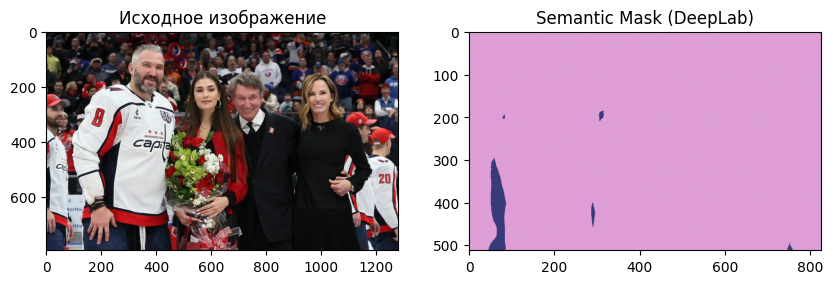

In [3]:
import torch
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import matplotlib.pyplot as plt

# Загрузка изображения
img_path = "/content/Foto_Ovechkin.jpg"  # замените на свой путь
image = Image.open(img_path).convert('RGB')

# Преобразование
preprocess = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image).unsqueeze(0)

# Модель DeepLabV3+
model = deeplabv3_resnet101(pretrained=True).eval()

with torch.no_grad():
    output = model(input_tensor)['out'][0]
semantic_mask = output.argmax(0).byte().cpu().numpy()

# Отображение
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image); plt.title("Исходное изображение")
plt.subplot(1, 2, 2)
plt.imshow(semantic_mask, cmap='tab20b'); plt.title("Semantic Mask (DeepLab)")
plt.show()


## 🧪 Практика: Instance сегментация через Mask R-CNN

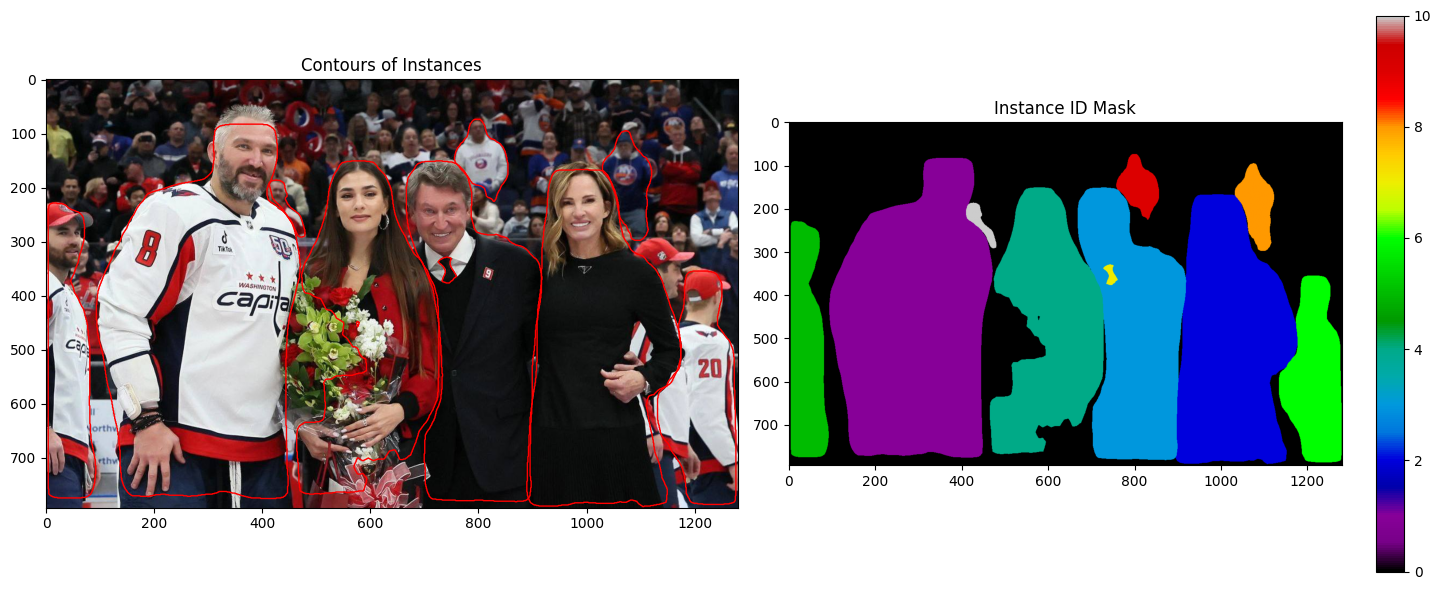

In [5]:
import torch
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 📥 Загружаем изображение
img_path = "/content/Foto_Ovechkin.jpg"  # замените на свой путь
image = Image.open(img_path).convert('RGB')

# 🔁 Преобразование для модели
transform = transforms.Compose([
    transforms.ToTensor(),
])
img_tensor = transform(image)

# 🧠 Загрузка модели Mask R-CNN
model = maskrcnn_resnet50_fpn(pretrained=True).eval()

# 📈 Предсказание
with torch.no_grad():
    prediction = model([img_tensor])[0]

# 🧩 Создание instance_mask (ID для каждого объекта)
instance_mask = np.zeros(img_tensor.shape[1:], dtype=np.uint8)

instance_id = 1
for i, (mask, score) in enumerate(zip(prediction['masks'], prediction['scores'])):
    if score > 0.8:
        m = mask[0].cpu().numpy()
        binary_mask = m > 0.5
        instance_mask[binary_mask] = instance_id
        instance_id += 1

# 🎨 Визуализация: контуры и ID-маска
plt.figure(figsize=(15, 6))

# Контуры
plt.subplot(1, 2, 1)
plt.imshow(image)
for i, mask in enumerate(prediction['masks']):
    if prediction['scores'][i] > 0.8:
        m = mask[0].cpu().numpy()
        plt.contour(m > 0.5, colors='r', linewidths=1)
plt.title("Contours of Instances")

# ID карта
plt.subplot(1, 2, 2)
plt.imshow(instance_mask, cmap='nipy_spectral')
plt.title("Instance ID Mask")
plt.colorbar()

plt.tight_layout()
plt.show()



## 🧰 OpenCV-практика: объединение масок средствами OpenCV

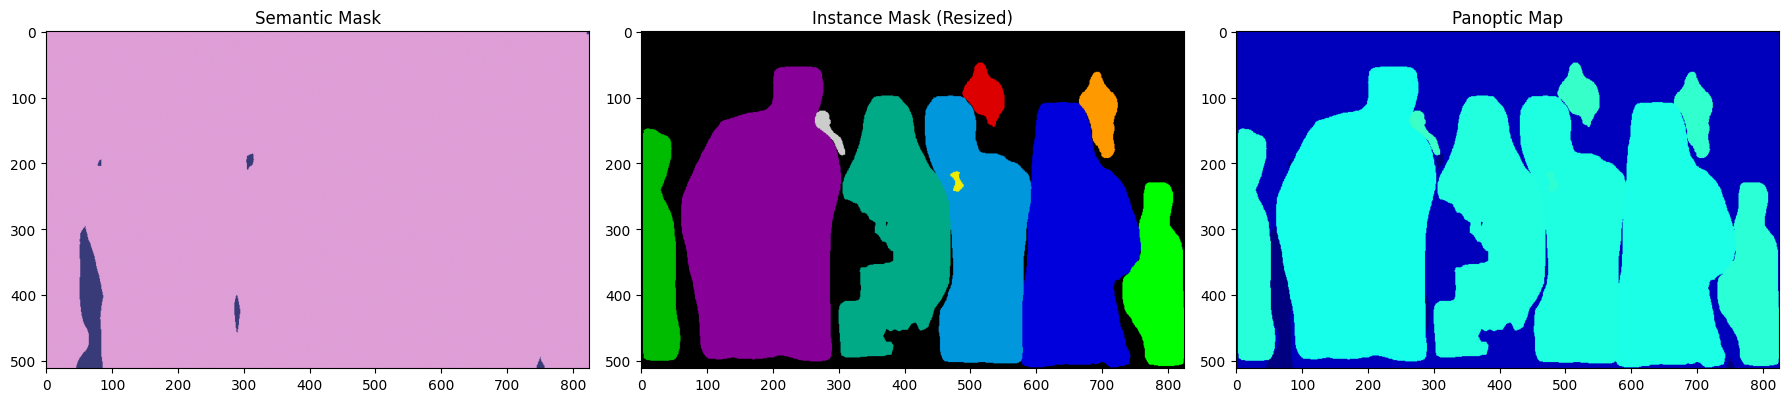

In [7]:
import cv2
import matplotlib.pyplot as plt

# Приведение instance_mask к размеру semantic_mask
instance_mask_resized = cv2.resize(instance_mask, (semantic_mask.shape[1], semantic_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

# Построение panoptic карты
panoptic_map = np.copy(semantic_mask)

instance_ids = np.unique(instance_mask_resized)
for uid in instance_ids:
    if uid == 0:
        continue
    panoptic_map[instance_mask_resized == uid] = 100 + uid

# Визуализация
colored_panoptic = cv2.applyColorMap(panoptic_map.astype(np.uint8), cv2.COLORMAP_JET)

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.imshow(semantic_mask, cmap='tab20b')
plt.title("Semantic Mask")

plt.subplot(1, 3, 2)
plt.imshow(instance_mask_resized, cmap='nipy_spectral')
plt.title("Instance Mask (Resized)")

plt.subplot(1, 3, 3)
plt.imshow(colored_panoptic[..., ::-1])
plt.title("Panoptic Map")

plt.tight_layout()
plt.show()


Instance mask "лучше" только для объектов, а semantic mask — для фона.
Panoptic segmentation объединяет оба мира.

🧩 Подробное сравнение:
Сравнение	                      Semantic segmentation	Instance segmentation
Определяет класс каждого пикселя?	✅ Да	            ✅ Да (только у объектов)
Отличает отдельные объекты одного класса?	❌ Нет	    ✅ Да
Работает с фоновыми классами? (необъектными)	✅ Да (небо, дорога)	❌ Нет
Пример задачи	Сцена с дорогой, небом, травой	Люди, машины, животные
Маска фона (например, небо)	       🎯 Точная	🚫 Отсутствует
Маска объектов (например, 3 человека)	🧍+🧍+🧍 = "person"	🧍#1, 🧍#2, 🧍#3 — разные ID

🤖 Пример на сцене:
Допустим, у тебя изображение:

👨 Человек

🐕 Собака

🌳 Дерево

☁️ Небо

🛣️ Дорога

Semantic segmentation:
все пиксели определены:

👨 и 🐕 = "person", "dog"

🌳 = "tree"

☁️ = "sky"

🛣️ = "road"

НО: все люди будут одной маской — нельзя посчитать их

Instance segmentation:
человек 1, человек 2 — ✅

собака — ✅

НО:

дорога? ❌

небо? ❌

дерево? ❌ (если не распознаётся как объект)

💡 Вывод:
Panoptic segmentation = semantic_mask + instance_mask

🧍 У объектов будет индивидуальный ID

🌳 У фона будет свой класс

Каждый пиксель будет:

либо "фон + класс"

либо "объект + ID + класс"

🔬 Почему это важно:
В задачах:

автономного вождения

анализа сцены

построения карты

AR/VR, робототехники

тебе нужно знать и кто (что), и где, и сколько их, и что находится на фоне.

📌 Так что instance-сегментация не заменяет, а дополняет семантику. Только вместе они дают полную картину мира.